# Getting Heads 2

This notebook aims to develop a new method of head detection using insights gained from the first version of this data. This new effort improves on the previous one in two main ways:

* head selection is performed using Text Fabric templates, which offers a clearer, more transparent way to select and filter data
* aims to track and address all edge cases

Most of the rationale and rules generated in [getting_heads.ipynb](getting_heads.ipynb) are carried over to this present notebook.

In [1]:
from tf.extra.bhsa import Bhsa
from IPython.display import display
import collections, random, csv, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
A = Bhsa(hoist=globals(), silent=True)
print(f'running version {A.version} of BHSA...')

running version c of BHSA...


# Defining Heads

The basic definition of a phrase head from the previous version is carried over here, which is:
> the word with a part of speech after which a phrase type is named

As applied in the previous effort, this includes a secondary criterion:
> the word which semantically determines grammatical agreement

This latter case thus excludes quantifiers such as כל and cardinal numbers that are in construct or attribution to a given word.

From the point of view of the ETCBC database, heads can be extracted using the `subphrase` object and its relations. These relations are not always coded in a transparent or beneficial way. But they are at least useful enough to disambiguate independent words from dependent words. From the ETCBC database perspective, we add a third criterion:
> a word contained in an independent subphrase or a subphrase only dependent upon a quantifier


## Tracking Head Selection

Using the guiding principles listed above, we will follow a process of deduction for assigning heads to phrases. We select all phrases to track which heads are accounted for.

In [3]:
remaining_phrases = set(result[0] for result in A.search('phrase'))
covered_phrases = set()
remaining_types = list(feat[0] for feat in F.typ.freqList(nodeTypes='phrase'))

  0.08s 253207 results


All phrase to head assignments will be mad in the dictionary below.

In [4]:
phrase2heads = collections.defaultdict(set)

The functions below programmatically record the heads in `phrase2heads` and remove them from the remaining set. `query_heads` iterates through a dictionary of queries and calls `record_head` on each result. `heads_status` provides a simple readout of what phrases remain to be analyzed.

In [5]:
def record_head(phrase, head, mapping=phrase2heads, remaining=remaining_phrases, covered=covered_phrases):
    '''
    Simple function to track phrases
    with heads that are accounted for
    and to modify the phrase2heads
    dict, which is a mapping from a phrase
    node to its head nodes.
    '''
    # try/except accounts for phrases with plural heads, 
    # one of which is already recorded
    try:
          remaining.remove(phrase)
    except: 
        pass
    
    mapping[phrase].add(head) # record it
    covered.add(phrase)
    
def query_heads(querydict, phrasei=0, headi=1, sets={}):
    '''
    Runs queries on phrasetype/query dict.
    Reports results.
    Adds results.
    
    phrasei - the index of the phrase result in the search template.
    headi - the index of the head result in the search template.
    sets - custom sets for TF search
    '''
    for phrasetype, query in querydict.items():
        print(f'running query on {phrasetype}')
        results = A.search(query, silent=True, sets=sets)
        print(f'\t{len(results)} results found')
        for res in results:
            phrase, head = res[phrasei], res[headi]
            record_head(phrase, head)
            
def heads_status():
    # simply prints accounted vs unaccounted heads
    print(f'{len(covered_phrases)} phrases matched with a head...')
    print(f'{len(remaining_phrases)} phrases remaining...')

# Simple Heads

The selection of heads for certain phrase types is very straightforward. Those are defined in the templates below and are subsequently applied. These phrase types are selected based on the survey of their subphrase relations as found in the old notebook.

In [6]:
simp_heads = dict(

PPrP = '''
% personal pronoun

phrase typ=PPrP
    word pdp=prps

''',

DPrP = '''
% demonstrative pronoun

phrase typ=DPrP
    word pdp=prde

''',

InjP = '''
% interjectional

phrase typ=InjP
    word pdp=intj

''',

NegP = '''
% negative

phrase typ=NegP
    word pdp=nega

''',

InrP = '''
% interrogative

phrase typ=InrP
    word pdp=inrg

''',
    
IPrP = '''
% interrogative pronoun

phrase typ=IPrP
    word pdp=prin

''',

) # end of dictionary

### Make Queries, Record Heads, See What Remains

Here we run the queries and run `record_head` over each result. In all of the templates the head is the second item in the result tuple.

In [7]:
query_heads(simp_heads)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on PPrP
	4392 results found
running query on DPrP
	791 results found
running query on InjP
	1883 results found
running query on NegP
	6742 results found
running query on InrP
	1291 results found
running query on IPrP
	798 results found

 <><><><><><><><><><><><><><><><><><><><> 

15866 phrases matched with a head...
237341 phrases remaining...


### Find Remaining Phrases

What phrases with the above types remain unaccounted for?

In [8]:
unaccounted_simp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) in simp_heads)
len(unaccounted_simp)

0

In [9]:
for typ in simp_heads:
    remaining_types.remove(typ)
print(remaining_types)

['VP', 'PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


# Mostly Simple Heads

The next set of heads require a bit more care since they can contain a bigger variety of relationships.

## VP
There is only one complication for the VP: that is that there is one VP that has more than one verb:

In [10]:
mult_verbs = A.search('''

phrase typ=VP
/with/
    word pdp=verb
    < word pdp=verb
/-/
''')
A.show(mult_verbs, condenseType='clause', withNodes=True)

  1.29s 1 result




**clause** *1*



The template below excludes this case without ignoring VP's that do not necessarily begin with a verb.

In [11]:
VP = '''

phrase typ=VP
    
    head:word pdp=verb
    
    /without/
    phrase
        word pdp=verb
        < head
    /-/

'''

VP_search = A.search(VP)

for phrase, head in VP_search:
    record_head(phrase, head)
    
heads_status()

  1.53s 69024 results
84890 phrases matched with a head...
168317 phrases remaining...


### VP Sanity Check

We double check that the indicated phrase above only has one head.

In [12]:
phrase2heads[893310]

{403602}

See what's left...

In [13]:
unaccounted_vp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'VP')
len(unaccounted_vp)

0

In [14]:
remaining_types.remove('VP')
print(remaining_types)

['PP', 'CP', 'NP', 'PrNP', 'AdvP', 'AdjP']


## CP

The conjunction phrase is relatively straightforward. But there are 1140 cases where the conjunction is technically headed by a preposition in the ETCBC data. These are phrases such as בטרם and בעבור (see the more detailed analysis in the prev. notebook). It is not clear at all why the ETCBC encodes these as conjunction phrases. This is almost certainly a confusion of the formal `typ` value and the functional `function` label (with a value of `Conj`). Nevertheless, here we make a choice to select the preposition as the true head.

In a BHSA2, these cases ought to be repaired.

In [15]:
cp_heads = dict(

conj = '''

phrase typ=CP
/without/
    word pdp=prep
/-/
    head:word pdp=conj
    /without/
    word pdp=conj
    <: head
    /-/

''',
    
prep_conj = '''

phrase typ=CP
    =: word pdp=prep

'''

)



In [16]:
query_heads(cp_heads)
        
print('\n', '<>'*20, '\n')
heads_status()

running query on conj
	50675 results found
running query on prep_conj
	1140 results found

 <><><><><><><><><><><><><><><><><><><><> 

136705 phrases matched with a head...
116502 phrases remaining...


### CP Sanity Check

In [17]:
unaccounted_cp = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'CP')
len(unaccounted_cp)

666

In [18]:
remaining_types.remove('CP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP', 'AdjP']


## AdjP

The adjective phrase always occurs with a word that has a `pdp` of adjective: 

In [19]:
A.search('''

phrase typ=AdjP
/without/
    word pdp=adjv
/-/

''')

  0.64s 0 results


[]

By playing with the `head:word pdp=` value below, I ascertain that there are 8 uses of `subs` as a head in this phrase type, and 1 use of `advb` as a head. These variants are due to the phrase containing multiple heads, with the first having a `pdp` of `adjv`, formally making the phrase an `AdjP`. 

The selection criteria is as follows. We want all cases in an adjective phrase where the word has a `pdp` of `adjv`, `subs`, or `advb`. The head candidate must not be found in a modifying subphrase, defined as `rela=adj|atr|rec|mod|dem` (remember that a word can often occur in multiple subphrases); and the only acceptable values for phrase_atom and subphrase relations are either `NA` (no relation), or `Para`/`par` (coordinate relation). In this latter case, it is expected here that the first requirement will prevent spurious parallel results (that is, words that are parallel not to a head but to a modiying element).

The requirements are set in the pattern below.

In [20]:
AdjP = '''

phrase typ=AdjP
    phrase_atom rela=NA|Para
        head:word pdp=adjv|subs|advb
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
'''
AdjP = A.search(AdjP)

for res in AdjP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.71s 1871 results
138454 phrases matched with a head...
114753 phrases remaining...


In [21]:
unaccounted_AdjP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdjP')
len(unaccounted_AdjP)

0

In [22]:
remaining_types.remove('AdjP')
print(remaining_types)

['PP', 'NP', 'PrNP', 'AdvP']


## AdvP

The adverb phrase has similar internal relations to AdjP. Thus, we apply the same basic template search.

By modifying `pdp=` parameter, I have found 2 examples of a preposition in the AdvP, which is caused by a prepositional phrase_atom coordinated with the `AdvP` phrase atom. These mixed cases must be dealt with imperfectly by taking the preposition head literally. It is then up to the user of the heads feature to include/exclude cases such as these, or to depend on the phrase_atoms.

There are two cases where an `inrg` serves as a head element. These are incorrect encodings, as they belong under their own phrase type of `InrP`. These should be fixed in BHSA2. For now the `inrg` is excluded as a phrase head as they are followed by a `advb` which is probably triggering these phrases' classification.

There is one case in sentence 68 from Exodus 8:20 where a כל quantifier is incorrectly identified as a phrase head. This is because it precedes a prepositional element. That case is also excluded below.

In [23]:
AdvP = '''

phrase typ=AdvP
    phrase_atom rela=NA|Para
        head:word pdp=advb|subs|nmpr|prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a prepositional form
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
AdvP = A.search(AdvP)

for res in AdvP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.71s 5776 results
144113 phrases matched with a head...
109094 phrases remaining...


In [24]:
unaccounted_AdvP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'AdvP')
len(unaccounted_AdvP)

0

In [25]:
remaining_types.remove('AdvP')
print(remaining_types)

['PP', 'NP', 'PrNP']


## PP

The same method used above applies to prepositional phrases.

In [26]:
PP = '''

phrase typ=PP
    phrase_atom rela=NA|Para
        head:word pdp=prep
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
'''
PP = A.search(PP)

for res in PP:
    phrase, head = res[0], res[2]
    record_head(phrase, head)
    
heads_status()

  1.45s 61544 results
201595 phrases matched with a head...
51612 phrases remaining...


In [27]:
unaccounted_PP = set(phrase for phrase in remaining_phrases
                          if F.typ.v(phrase) == 'PP')
len(unaccounted_PP)

0

In [28]:
remaining_types.remove('PP')
print(remaining_types)

['NP', 'PrNP']


## NP and PrNP

The noun phrase is the most complicated for head selection due to the presence of quantifers. 

In [29]:
custom_quants = {'KL/', 'M<V/', 'JTR/', # quantifier lexemes, others?
                 'M<FR/', 'XYJ/'}
quantlexs = '|'.join(custom_quants)

# for the Hebrew idiom: בנ + quantifier for age
son_quantifiers = set(res[0] for res in A.search('''

word lex=BN/ st=c nu=sg
<: word ls=card

'''))

# for use as quantifier set
quantifiers = set(w for w in F.otype.s('word')
                  if F.lex.v(w) in custom_quants
                  or F.ls.v(w) == 'card')

quantifiers |= (son_quantifiers)

  0.81s 127 results


In [30]:
NP_heads = dict(
    
NP_noqant = f'''

phrase typ=NP|PrNP
    phrase_atom rela=NA|Para
        head:word pdp=subs|adjv|nmpr
        
% word is not equal to a quantifier
        /without/
        = quant
        /-/
        
% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            head
        /or/
        /without/
        subphrase
            head
        /-/
        /-/
        
% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            head
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: head
        /-/
        
% ensure word is not immediately preceded by a preposition
        /without/
        phrase_atom
            word pdp=prep
            <: head
        /-/
        /without/
        phrase_atom
            word pdp=prep
            <: word pdp=art
            <: head
        /-/
''',

NP_quant_alone = f'''

phrase typ=NP|PrNP
    phrase_atom rela=NA|Para
        quantifier:quant
            
% quantifier does not precede a quantified element
        /without/
        phrase_atom
            quantifier
            < w1:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
            
% look to see whether potential quantified element is not preceded by prep 
            /without/
            word pdp=prep
            <: word pdp=art
            <: w1
            /-/
            /without/
            word pdp=prep
            <: w1
            /-/ 
        /-/

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
        
% ensure word is not immediately preceded by a construct form
        /without/
        phrase_atom
            word st=c
            <: quantifier
        /-/

''',

NP_quantified = f'''

phrase typ=NP|PrNP
    phrase_atom rela=NA|Para
    
% phrase atom must have quantifier as formal head:
    /with/
        quantifier:quant
        
% quantifier precedes a quantified element
        /with/
        phrase_atom
            quantifier
            < word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card
        /-/

% require either NA subphrase relation
% or no subphrase embedding:
        /with/
        subphrase rela=NA|par
            quantifier
        /or/
        /without/
        subphrase
            quantifier
        /-/
        /-/

% exclude uses as modifier:
        /without/
        subphrase rela=adj|atr|rec|mod|dem
            quantifier
        /-/
    /-/
    
        head:word pdp=subs|adjv|advb|nmpr|prde|prps lex#{quantlexs} ls#card

% require head word to be construct and adjacent to any quantifier in the phrase atom:
        /with/
        phrase_atom
            quant
            <: head

        /or/
        phrase_atom
            quant
            <: word pdp=art
            <: head
        /-/
    
''')

query_heads(NP_heads, headi=2, sets={'quant': quantifiers})
print('\n', '<>'*20, '\n')
heads_status()

running query on NP_noqant
	51726 results found
running query on NP_quant_alone
	1717 results found
running query on NP_quantified
	3557 results found

 <><><><><><><><><><><><><><><><><><><><> 

252539 phrases matched with a head...
668 phrases remaining...


There are only 2 phrases left. Let's have a look at the remaining phrases...

In [31]:
for phrase in list(remaining_phrases)[:100]:
    print('{} {}:{}'.format(*T.sectionFromNode(phrase)))
    print(f'phrase {F.number.v(phrase)}')
    A.prettyTuple((phrase,), seqNumber=phrase, withNodes=True, condenseType='clause')

Genesis 3:6
phrase 2




**Result** *652259*



Genesis 4:7
phrase 2




**Result** *652578*



Genesis 7:16
phrase 1




**Result** *653432*



Genesis 7:23
phrase 2




**Result** *653515*



Genesis 13:9
phrase 2




**Result** *654855*



Genesis 13:16
phrase 1




**Result** *654936*



Genesis 14:23
phrase 2




**Result** *655161*



Genesis 15:4
phrase 1




**Result** *655237*



Genesis 17:17
phrase 2




**Result** *655786*



Genesis 18:21
phrase 2




**Result** *656147*



Genesis 19:15
phrase 2




**Result** *656543*



Genesis 20:7
phrase 2




**Result** *656954*



Genesis 24:7
phrase 2




**Result** *658098*



Genesis 24:7
phrase 2




**Result** *658102*



Genesis 24:8
phrase 2




**Result** *658119*



Genesis 24:41
phrase 2




**Result** *658527*



Genesis 24:49
phrase 2




**Result** *658666*



Genesis 29:12
phrase 2




**Result** *660736*



Genesis 30:1
phrase 2




**Result** *661062*



Genesis 31:8
phrase 2




**Result** *661661*



Genesis 31:50
phrase 2




**Result** *662212*



Genesis 31:52
phrase 2




**Result** *662246*



Genesis 33:11
phrase 2




**Result** *662799*



Genesis 34:11
phrase 1




**Result** *663041*



Genesis 34:17
phrase 2




**Result** *663110*



Genesis 39:23
phrase 1




**Result** *665141*



Genesis 42:16
phrase 2




**Result** *666221*



Genesis 43:5
phrase 2




**Result** *666600*



Genesis 45:26
phrase 2




**Result** *667811*



Genesis 47:6
phrase 2




**Result** *668219*



Exodus 1:16
phrase 2




**Result** *669654*



Exodus 3:11
phrase 2




**Result** *670220*



Exodus 4:31
phrase 2




**Result** *670840*



Exodus 7:27
phrase 2




**Result** *671762*



Exodus 8:17
phrase 1




**Result** *671997*



Exodus 9:2
phrase 1




**Result** *672171*



Exodus 9:21
phrase 2




**Result** *672397*



Exodus 10:2
phrase 2




**Result** *672601*



Exodus 10:4
phrase 1




**Result** *672636*



Exodus 12:4
phrase 2




**Result** *673150*



Exodus 12:10
phrase 1




**Result** *673215*



Exodus 12:48
phrase 2




**Result** *673671*



Exodus 13:13
phrase 2




**Result** *673844*



Exodus 14:13
phrase 1




**Result** *674146*



Exodus 15:26
phrase 1




**Result** *674642*



Exodus 16:17
phrase 2




**Result** *674917*



Exodus 16:18
phrase 1




**Result** *674928*



Exodus 20:4
phrase 2




**Result** *676092*



Exodus 20:4
phrase 2




**Result** *676095*



Exodus 20:25
phrase 2




**Result** *676283*



Exodus 21:5
phrase 2




**Result** *676352*



Exodus 21:7
phrase 2




**Result** *676377*



Exodus 21:9
phrase 2




**Result** *676401*



Exodus 21:11
phrase 2




**Result** *676415*



Exodus 21:13
phrase 2




**Result** *676432*



Exodus 21:14
phrase 2




**Result** *676447*



Exodus 21:18
phrase 2




**Result** *676477*



Exodus 21:20
phrase 2




**Result** *676507*



Exodus 21:22
phrase 2




**Result** *676527*



Exodus 21:23
phrase 2




**Result** *676550*



Exodus 21:26
phrase 2




**Result** *676572*



Exodus 21:27
phrase 2




**Result** *676582*



Exodus 21:28
phrase 2




**Result** *676589*



Exodus 21:29
phrase 2




**Result** *676606*



Exodus 21:33
phrase 2




**Result** *676655*



Exodus 21:33
phrase 2




**Result** *676660*



Exodus 21:35
phrase 2




**Result** *676681*



Exodus 22:11
phrase 2




**Result** *676858*



Exodus 22:13
phrase 2




**Result** *676873*



Exodus 22:15
phrase 2




**Result** *676897*



Exodus 29:27
phrase 2




**Result** *679088*



Exodus 29:34
phrase 2




**Result** *679160*



Exodus 30:33
phrase 2




**Result** *679578*



Exodus 32:32
phrase 2




**Result** *680255*



Exodus 34:20
phrase 2




**Result** *680871*



Exodus 40:37
phrase 2




**Result** *682740*



Leviticus 1:10
phrase 2




**Result** *682856*



Leviticus 1:14
phrase 2




**Result** *682902*



Leviticus 2:4
phrase 2




**Result** *682988*



Leviticus 2:5
phrase 2




**Result** *683000*



Leviticus 2:7
phrase 2




**Result** *683018*



Leviticus 2:14
phrase 2




**Result** *683087*



Leviticus 3:1
phrase 2




**Result** *683113*



Leviticus 3:6
phrase 2




**Result** *683173*



Leviticus 3:12
phrase 2




**Result** *683232*



Leviticus 4:13
phrase 2




**Result** *683402*



Leviticus 4:27
phrase 2




**Result** *683569*



Leviticus 4:32
phrase 2




**Result** *683633*



Leviticus 5:3
phrase 2




**Result** *683720*



Leviticus 5:7
phrase 2




**Result** *683782*



Leviticus 5:9
phrase 1




**Result** *683819*



Leviticus 5:11
phrase 2




**Result** *683842*



Leviticus 5:17
phrase 2




**Result** *683938*



Leviticus 6:9
phrase 1




**Result** *684170*



Leviticus 6:20
phrase 2




**Result** *684278*



Leviticus 6:21
phrase 2




**Result** *684294*



Leviticus 7:16
phrase 2




**Result** *684454*



Leviticus 7:16
phrase 1




**Result** *684464*



Leviticus 7:17
phrase 1




**Result** *684469*



Leviticus 7:18
phrase 2




**Result** *684476*



In [32]:
patched_heads = dict(

patch1 = '''

book book@en=Psalms
    chapter chapter=59
        verse verse=4
            phrase number=4
                word lex=L>
''',

patch2 = '''

book book@en=Proverbs
    chapter chapter=23
        verse verse=29
            phrase number=2
                word lex=>WJ
'''

) # end of dict

query_heads(patched_heads, phrasei=3, headi=4)
print('\n', '<>'*20, '\n')
heads_status()

running query on patch1
	2 results found
running query on patch2
	1 results found

 <><><><><><><><><><><><><><><><><><><><> 

252541 phrases matched with a head...
666 phrases remaining...


# Evaluating Heads v.2

## Vs. Stephen Ku's Evaluation of `headsv.1`


Stephen Ku has kindly and laboriously documented missing head cases for heads v.1 (from April 21, see doc [here](https://docs.google.com/document/d/1miNomMzlutDu-cVVXa153D7kO03El-J1-CWjt6N5xJk/edit)). Below, I display Stephen's feedback and check to make sure his examples are indeed cured.

In [33]:
ku_eval = pd.read_csv('stephen_ku_heads_eval.csv', header=1).fillna('')
ku_eval['Decision'] = ''
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,
5,Num 31:17,missing כֹּל before אִשָּׁה,,
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,


In [34]:
abb2book = {'Gen': 'Genesis', 
            'Num':'Numbers', 
            'Deut': 'Deuteronomy',
            'Judg': 'Judges',
            '1_Sam': '1_Samuel',
            '1_Kgs': '1_Kings',
            'Isa': 'Isaiah',
            'Ps': 'Psalms',
            'Job': 'Job',
            'Prov': 'Proverbs',
            '2_Chr': '2_Chronicles'}

my_decisions = {'not yet going out of clause boundaries': {0,1, 2 ,6, 8, 11, 12 , 13, 16, 18},
                'fixed': {3, 4, 5, 7, 9, 10, 14, 15, 17, 19},}

for decision, numbers in my_decisions.items():
    for num in numbers:
        ku_eval.loc[num]['Decision'] = decision
        

for i, ref in enumerate(ku_eval.Verse):

    book, ch_vs = ref.split() if not re.match('^\d', ref) else ref.replace(' ', '_', 1).split()
    book = abb2book[book.strip()]
    chapter, verse = ch_vs.split(':')
    
    # get TF ref
    tf_node = T.nodeFromSection((book, int(chapter), int(verse)))
    for phrase in L.d(tf_node, 'phrase'):
        if 'KL/' in [F.lex.v(w) for w in L.d(phrase, 'word')]:
            print(ref)
            print(f'v1 issue: {ku_eval.Issue[i]}')
            print(f'v2 update: {ku_eval.Decision[i]}')
            A.prettyTuple((phrase,)+tuple(phrase2heads[phrase]), seqNumber=f'Ku Eval {i}', condenseType='clause', withNodes=True)

Gen 39:4
v1 issue: missing יֵשׁ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 0*



Num 5:2
v1 issue: missing two כֹּל’s (the one before צָר֖וּעַ and the one before זָ֑ב)
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 1*



Num 5:2
v1 issue: it’s able to find the last כֹ֖ל but not טָמֵא following it
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 2*



Num 31:7
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 3*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing זָכָ֖ר after כֹּל
v2 update: fixed




**Result** *Ku Eval 4*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Num 31:17
v1 issue: missing כֹּל before אִשָּׁה
v2 update: fixed




**Result** *Ku Eval 5*



Deut 25:18
v1 issue: missing חשׁל after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 6*



Judg 13:4
v1 issue: missing טָמֵֽא after כֹּל
v2 update: fixed




**Result** *Ku Eval 7*



1 Sam 14:36
v1 issue: missing טוֹב after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 8*



1 Kgs 11:15
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 9*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



1 Kgs 11:16
v1 issue: missing זָכָר after כֹּל
v2 update: fixed




**Result** *Ku Eval 10*



Isa 43:7
v1 issue: missing הַנִּקְרָ֣א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 11*



Ps 73:27
v1 issue: missing זֹונֶ֥ה after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 12*



Ps 119:118
v1 issue: missing שֹׁוגִ֣ים after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 13*



Job 40:11
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 14*



Job 40:12
v1 issue: missing גֵּ֝אֶ֗ה after כֹּל
v2 update: fixed




**Result** *Ku Eval 15*



Prov 6:29
v1 issue: missing נֹּגֵ֥עַ after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 16*



Prov 20:8
v1 issue: missing רָֽע after כֹּל
v2 update: fixed




**Result** *Ku Eval 17*



2 Chr 13:9
v1 issue: missing בָּ֗א after כֹּל
v2 update: not yet going out of clause boundaries




**Result** *Ku Eval 18*



2 Chr 22:1
v1 issue: missing רִאשֹׁנִים֙ after כֹּל
v2 update: fixed




**Result** *Ku Eval 19*



By way of overview, here are the previous issues and the new decisions.

In [35]:
ku_eval

,Verse,Issue,Cause,Decision
0,Gen 39:4,missing יֵשׁ after כֹּל,יֵשׁ is not in the same clause as כֹּל,not yet going out of clause boundaries
1,Num 5:2,missing two כֹּל’s (the one before צָר֖וּעַ an...,,not yet going out of clause boundaries
2,Num 5:2,it’s able to find the last כֹ֖ל but not טָמֵא ...,טָמֵא belongs to another clause and is not mar...,not yet going out of clause boundaries
3,Num 31:7,missing זָכָר after כֹּל,זָכָר is an adjective,fixed
4,Num 31:17,missing זָכָ֖ר after כֹּל,זָכָר is an adjective,fixed
5,Num 31:17,missing כֹּל before אִשָּׁה,,fixed
6,Deut 25:18,missing חשׁל after כֹּל,נֶּחֱשָׁלִ֣ים belongs to another clause and is...,not yet going out of clause boundaries
7,Judg 13:4,missing טָמֵֽא after כֹּל,טָמֵֽא is an adjective,fixed
8,1 Sam 14:36,missing טוֹב after כֹּל,טוֹב is an adjective,not yet going out of clause boundaries
9,1 Kgs 11:15,missing זָכָר after כֹּל,זָכָר is an adjective,fixed


As indicated in the decisions, I have decided to not yet extend beyond the clause boundaries for situations where כל quantifies an entire clause. That step may require further methodological evaluation about the role of clause and phrase embeddings. This is a task that is better suited within a whole new data model, such as BHSA2 can provide.

All other cases have been fixed by the new heads selection procedures. This already shows that the new heads performs better than the previous version.

## Statistical Evaluation

Below I provide statistical counts and visualizations for the head assignments. 

In [36]:
typ2pdpcounts = collections.defaultdict(lambda: collections.Counter())

for phrase, heads in phrase2heads.items():
    typ = F.typ.v(phrase)
    pdps = [F.pdp.v(head) for head in heads]
    typ2pdpcounts[typ].update(pdps)
    
typ2pdpcounts = pd.DataFrame(typ2pdpcounts).fillna(0)

Parts of Speech for PPrP


,PPrP
prps,4392.0


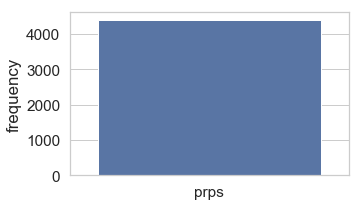

Parts of Speech for DPrP


,DPrP
prde,791.0


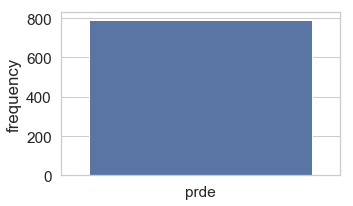

Parts of Speech for InjP


,InjP
intj,1883.0


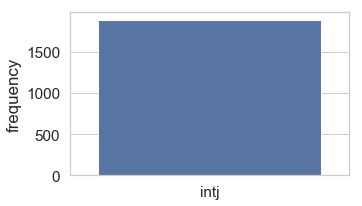

Parts of Speech for NegP


,NegP
nega,6742.0


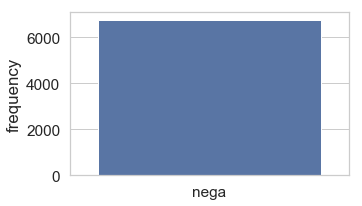

Parts of Speech for InrP


,InrP
inrg,1291.0


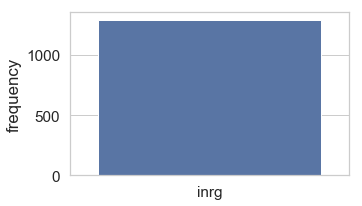

Parts of Speech for IPrP


,IPrP
prin,798.0


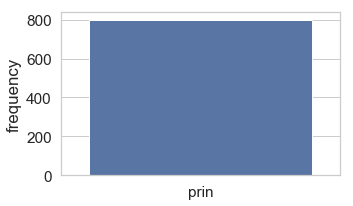

Parts of Speech for VP


,VP
verb,69024.0


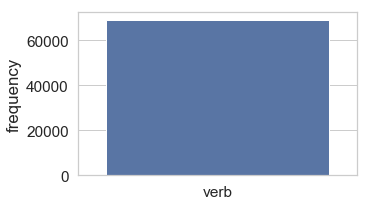

Parts of Speech for CP


,CP
conj,50675.0
prep,1140.0


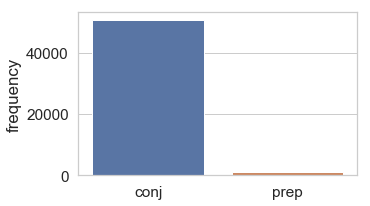

Parts of Speech for AdjP


,AdjP
adjv,1866.0
subs,4.0
advb,1.0


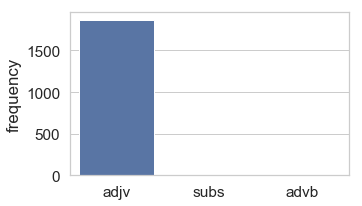

Parts of Speech for AdvP


,AdvP
advb,5172.0
subs,368.0
nmpr,234.0
prep,2.0


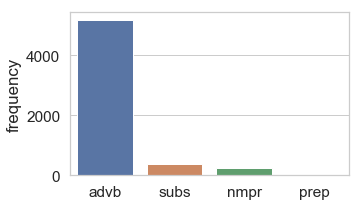

Parts of Speech for PP


,PP
prep,61544.0


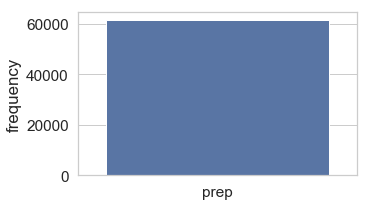

Parts of Speech for NP


,NP
subs,44696.0
nmpr,150.0
adjv,127.0
prde,50.0
prps,4.0
nega,2.0
intj,1.0


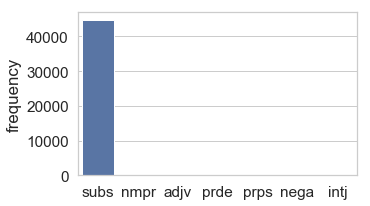

Parts of Speech for PrNP


,PrNP
nmpr,11630.0
subs,337.0


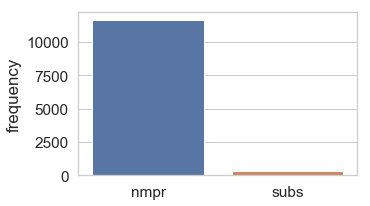

In [37]:
sns.set(style='whitegrid', font_scale=1.4)

for typ in typ2pdpcounts:
    positive = typ2pdpcounts[typ][typ2pdpcounts[typ] > 0].sort_values(ascending=False)
    
    print(f'Parts of Speech for {typ}')
    display(pd.DataFrame(positive))
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x=positive.index, y=positive)
    plt.ylabel('frequency')
    plt.show()

## Evaluating Quantifiers

By far, quantifiers are the most tricky of issues involved in picking out heads. Let's evaluate how many and which quantifiers have been selected.

In all cases, a quantifier should only be selected if it is not followed by a quantified noun. These quantifiers are selected with the `NP_quant_alone` query above, which identified 1706 cases. A quantifier should not have been selected in any other case.

In [38]:
1717-1706

11

In [39]:
len([head for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) in {'NP', 'PrNP'}]) - 1706

11

This is a good result. Let's check whether there are quantifiers in other phrase types.

In [40]:
A.show([(phrase, head) for phrase, heads in phrase2heads.items()
            for head in heads if head in quantifiers
            if F.typ.v(phrase) not in {'NP', 'PrNP'}], condenseType='phrase', withNodes=True)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*



These quantifiers are all well-chosen. 

Next, I want to check whether there are any cases of a cardinal number and a substantive occuring together as head elements. These combinations often identify mismatched quantifiers.

In [42]:
len([phrase for phrase, heads in phrase2heads.items()
         if [w for w in heads if F.ls.v(w) == 'card']
         and [w for w in heads if F.ls.v(w) != 'card']])

22

In [43]:
A.show([(phrase,)+tuple(heads) for phrase, heads in phrase2heads.items()
         if [w for w in heads if F.ls.v(w) == 'card']
         and [w for w in heads if F.ls.v(w) != 'card']], condenseType='phrase', withNodes=True, end=100)



**phrase** *1*





**phrase** *2*





**phrase** *3*





**phrase** *4*





**phrase** *5*





**phrase** *6*





**phrase** *7*





**phrase** *8*





**phrase** *9*





**phrase** *10*





**phrase** *11*





**phrase** *12*





**phrase** *13*





**phrase** *14*





**phrase** *15*





**phrase** *16*





**phrase** *17*





**phrase** *18*





**phrase** *19*





**phrase** *20*





**phrase** *21*





**phrase** *22*



There are some problems here left to address...

<hr>

### Scratch Code

In [58]:
# # 29

# T.text(L.u(798340, 'verse')[0])

In [59]:
# randomphrases = list(phrase2heads.keys())
# random.shuffle(randomphrases)

In [60]:
# for i, phrase in enumerate([ph for ph in randomphrases if [w for w in L.d(ph, 'word') if F.ls.v(w) == 'card']]):
#     res = (phrase,)+tuple(phrase2heads[phrase])
#     if i < 100:
#         A.prettyTuple(res, seqNumber=i, condenseType='phrase', withNodes=True)

In [62]:
'''
Below are phrases I found with 
heads whose evaluation is incorrect
but with too complex semantics to be 
automatically evaluated with the existing
data
'''
complex_semantic_cases = [692470]